In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize
from dask_ml.wrappers import Incremental

from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
from scipy.stats import entropy

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
def read_trials(filename):
    pairs = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    print("num of trials: ",len(pairs))

    # Encode "nontarget" as 0, "target as 1"
    pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
    print(pairs.head())
    return pairs

def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER/FPR: ", fpr[minPt])
    print("FNR: ", fnr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

def run_test(score_func, sample_size = 0.10, ESPK = 0, TSPK = 0, n_features = 1, dask_array = False, pairs = None):

    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res

    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors , axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    if n_features>1: # This conditional halves the time if n_features==1
        scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=(len(dask_pairs), n_features), dtype='float64')
        scores = scores.rechunk((1000,500))
    res =  dask.array.from_array(np.array(dask_pairs['result']), (1000,))
    #res.rechunk((1000,500))
    if dask_array:
        pbar.unregister()
        return scores, res
    
    #scores = scores if delayed_res else scores.compute() #Turns out it is faster to do dd.compute(*(scores.compute())) if the inner func produces delayed objs
    scores = scores.compute(get = get)
    res = res.compute()
    pbar.unregister()
    
    return scores, res

def load_sample(enroll, test, eid = 4780420411, tid = 'fc_4779547143_0'):
    return enroll.loc[eid], test.loc[tid]

def sendScores(scores, res, name):
    pd.DataFrame(data=np.vstack((scores, res))).to_hdf("scores.h5", name)
    
def showH5(filename):
    with pd.HDFStore(filename) as store:
        print(store.keys())

In [3]:
showH5('scores.h5')

['/cos_10', '/cos_50', '/cos_samp_100k', '/kl_frame_100k', '/kl_spkr_10', '/kl_spkr_50', '/manhattan_spk_samp_100k', '/manhattan_spkr_10', '/var_10', '/var_50', '/var_samp_100k', '/zscore_10', '/zscore_samp_100k']


In [4]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

enroll_spk.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


In [4]:
pairs = read_trials("trials")

num of trials:  11725308
       enroll          test_id  result
0  4780420411  fc_4779547143_0       0
1  4780420411  fc_4779547143_1       0
2  4780420411  fc_4779547143_2       0
3  4780420411  fc_4779547143_3       0
4  4780420411  fc_4779547143_4       0


In [5]:
# some comparison functions

def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

def cos_with_variance(dist1, vect2):
    m = dist1.mean(axis=0)
    cos = 1 - cosine(m, vect2)
    v = dist1.var(axis=0)
    return np.concatenate([np.array([cos]), v])

In [8]:
spkr, test = load_sample(enroll=enroll_spk_raw, test=test_spk)

In [5]:
def read_spk2utt_utts(filename):  
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    df.index = df['id']
    df = df.drop('id', 1)
    return df 

In [6]:
enroll_utts = read_spk2utt_utts("enroll.spk2utt")
test_utts = read_spk2utt_utts("test.spk2utt")
enroll_utts.head()

,utt1,utt2,utt3,utt4,utt5
id,,,,,
4780420411,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...,nn_008b4a786aeb44d7ad7c892080dcee9b_78c9ad8db6...
4779876202,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...,nn_00bccfae85c34c66b4f1fafe04fc2893_1515bae937...
4778192381,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...,nn_00d380d1a8664888a2fcf7fe38277c35_25a2943474...
4780265567,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...,nn_00e16d3225bc4a22aff72e97dc8945eb_3c1033eec1...
4777987958,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...,nn_0160846368194819af7bab19847f92cb_77c66f3e7b...


In [7]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    
    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

# Load sample arks

In [9]:
%%time
enroll_ark_samp_tenth = pd.read_hdf("samp.h5", 'enroll_ark_samp_tenth')
test_ark_samp_tenth = pd.read_hdf("samp.h5", 'test_ark_samp_tenth')
u = pd.read_hdf("samp.h5", 'enroll_ark_samp_tenth_spkrs')
u_t = pd.read_hdf("samp.h5", 'test_ark_samp_tenth_spkrs')

In [4]:
pairs_samp = pd.read_hdf("samp.h5", 'pairs_samp_100k')

# Final sample stats

In [5]:
len(pairs_samp)

175026

In [167]:
len(pairs_samp[pairs_samp['result']==1])/len(pairs_samp)

0.0015883354473049719

# Define kl test functions

In [6]:
def kl_div(spkr, test):
    """Calc KL divergence of two speakers given utterance vectors of each"""
    # Use a sliding window of n_utterances of the test speaker to go over spkr's utterances 
    spkr = spkr.values
    test = test.values
    res = []
    for i in range(len(spkr)-len(test)+1):
        a = entropy(softmax(spkr[i:i+3].T), softmax(test.T))
        #a[a==np.inf] = 1000
        a[np.isnan(a)] = 0
        res.append(np.mean(a))
    return np.min(res)

def kl_div_frame(spkr_utts, test_utts):
    res_total = []
    for su in spkr_utts:
        for tu in test_utts:
            spkr = enroll_ark_samp_tenth.loc[su].values
            test = test_ark_samp_tenth.loc[tu].values
            # Just take cut-off KL for each utt pair for now
            minlen = min(len(spkr), len(test))
            a = entropy(softmax(spkr[:minlen].T), softmax(test[:minlen].T))
            a[np.isnan(a)] = 0
            res_total.append(np.mean(a))
    return np.median(res_total)

def kl_div_frame_delayed(spkr_utts, test_utts):
    res_total = []
    for su in spkr_utts:
        for tu in test_utts:
            spkr = delayed(enroll_ark_samp_tenth.loc[su].values)
            test = delayed(test_ark_samp_tenth.loc[tu].values)
        
            # Just take cut-off KL for each utt pair for now
            minlen = delayed(min)(delayed(len)(spkr), delayed(len)(test))
            one = spkr[:minlen].T
            two = test[:minlen].T
            a = delayed(entropy)(delayed(softmax)(one), delayed(softmax)(two))
#             a)[delayed(np.isnan)(a)] = 0
            res_total.append(delayed(np.mean)(a))
    return delayed(np.median)(res_total)

In [8]:
kl, res = run_test(kl_div, 0.5, enroll_spk_raw, test_spk_raw, pairs=pairs)

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed | 31min 22.4s
[########################################] | 100% Completed | 31min 22.5s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.2s


In [23]:
showH5('scores.h5')

['/cos_10', '/cos_samp_100k', '/kl_frame_100k', '/kl_spkr_10', '/manhattan_spk_samp_100k', '/var_samp_100k', '/zscore_10', '/zscore_samp_100k']


In [9]:
sendScores(kl, res, 'kl_spkr_50')

In [8]:
showH5('samp.h5')

['/enroll_ark_samp_tenth', '/enroll_ark_samp_tenth_spkrs', '/pairs_samp_100k', '/test_ark_samp_tenth', '/test_ark_samp_tenth_spkrs']


In [10]:
pairs_samp = pd.read_hdf('samp.h5', 'pairs_samp_100k')

In [11]:
kl, res = run_test(kl_div, 1, enroll_spk_raw, test_spk_raw, pairs=pairs_samp)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1min 17.1s
[########################################] | 100% Completed |  0.1s


In [12]:
sendScores(kl, res, 'kl_samp_100k')

In [13]:
kl_div_frame(enroll_utts.loc[4780176039], test_utts.loc['fc_4779876202_1'])

0.3493126023209686

In [20]:
len(pairs_samp)

175026

In [31]:
kl_scores_vert, res = run_test(kl_div_frame, 0.1, enroll_utts, test_utts, pairs=pairs_samp)

[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[                                        ] | 0% Completed |  4min 37.6s

Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:


[                                        ] | 0% Completed |  4min 37.7s

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/work4/kenneth/anaconda3/lib/pytho

[                                        ] | 0% Completed |  4min 37.7s


KeyboardInterrupt
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/work4/kenneth/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


[                                        ] | 0% Completed |  4min 37.8s


KeyboardInterrupt: 

# Below are tests to compute frame-level KL-div faster

In [40]:
%%time
e = pairs_samp['enroll'].values
t = pairs_samp['test_id'].values
kl_scores = []
for i in range(1000):
    kl_scores.append(delayed(kl_div_frame)(enroll_utts.loc[e[i]], test_utts.loc[t[i]]))

CPU times: user 223 ms, sys: 13.1 ms, total: 236 ms
Wall time: 234 ms


In [41]:
p = ProgressBar()
p.register()
kl_scores = dd.compute(*kl_scores)

[########################################] | 100% Completed | 43.0s
[########################################] | 100% Completed | 43.0s
[########################################] | 100% Completed | 43.0s
[########################################] | 100% Completed | 43.1s
[########################################] | 100% Completed | 43.1s


In [61]:
(pairs_samp['result'].values[:100000]==1).sum()

153

Threshold:  0.7147183095891161
EER/FPR:  0.15516740613138102
FNR:  0.15032679738562094


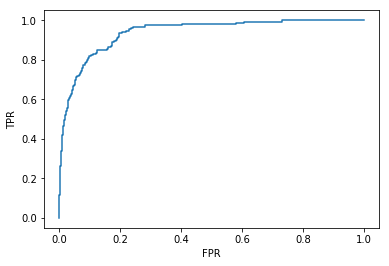

In [64]:
calcEER(1-np.array(kl_scores), pairs_samp['result'].values[:100000]) #orig, not vert

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.75945022, 0.76217483, 0.76489945, 0.76762406, 0.77034868,
        0.77307329, 0.77579791, 0.77852252, 0.78124714, 0.78397175,
        0.78669637]),
 <a list of 10 Patch objects>)

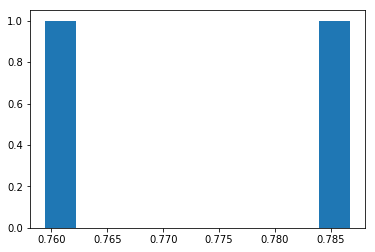

In [50]:
plt.hist(1-np.array(kl_scores))

Threshold:  0.7594502188766754
EER/FPR:  0.01903807615230461
FNR:  0.0


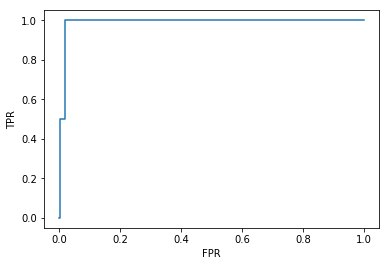

In [49]:
calcEER(1-np.array(kl_scores), pairs_samp['result'].values[:1000])

In [57]:
pd.DataFrame(data = np.vstack((kl_scores, pairs_samp['result'].values[:100000]))).to_hdf('scores.h5', 'kl_frame_100k')

# Other attempts at making computation faster fail

In [42]:
    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = enroll_utts.loc[x['enroll']] # Pandas series
        test_data = test_utts.loc[x['test_id']]
        res = kl_div_frame(enroll_data, test_data)
        return res

In [46]:
pairs_samp.sample(frac=0.00001, random_state=1)

,enroll,test_id,result
2762227,4782379417,fc_4781820323_5,0
3605123,4777416753,fc_4779933302_10,0


In [47]:
kl_scores = dd.from_pandas(pairs_samp.sample(frac=0.00001, random_state=1), npartitions=16).apply(score_vectors, axis=1, meta=('x','f8'))

KeyboardInterrupt: 

In [31]:
kl_scores_frames, res = run_test(kl_div_frame, 0.1, enroll_utts, test_utts, pairs=pairs_samp)

[                                        ] | 0% Completed | 13.0s
[                                        ] | 0% Completed | 13.1s


KeyboardInterrupt: 

In [102]:
kl_div_frame_delayed(enroll_utts.loc[4780420411], test_utts.loc['fc_4779547143_4']).compute()

TypeError: ('Invalid index type', <class 'dask.delayed.Delayed'>, Delayed('min-d0557957-8e64-45ca-9f41-3743e6b64b31'))

In [188]:
kl_scores, res = run_test(kl_div, 0.01, enroll_spk_raw, test_spk_raw)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  4min  7.2s
[########################################] | 100% Completed |  4min  7.3s
[########################################] | 100% Completed |  4min  7.3s
[########################################] | 100% Completed |  4min  7.4s
[########################################] | 100% Completed |  4min  7.5s
[########################################] | 100% Completed |  4min  7.5s
[###########

Threshold:  0.0002820034591774448
EER:  0.8920174958993986


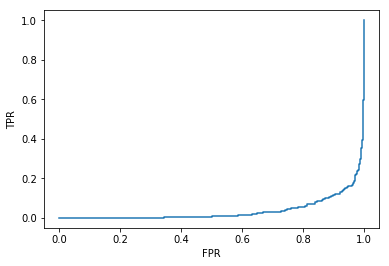

In [189]:
calcEER(kl_scores, res)

In [150]:
c, res = run_test(cos_similarity, 0.01, enroll_spk, test_spk)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.4s
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.6s
[########################################] | 100

Threshold:  0.9159605095883305
EER:  0.07061577364680154


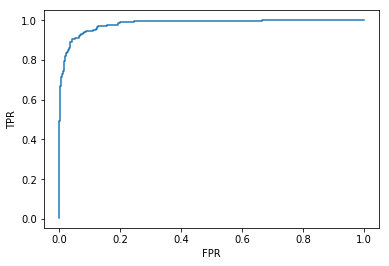

In [153]:
calcEER(c, res)

Threshold:  0.9157261720934429
EER:  0.0703082285401859


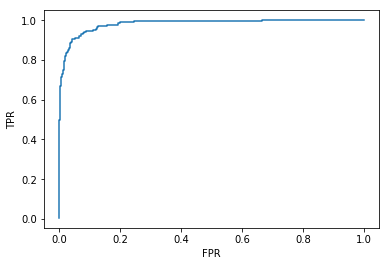

In [190]:
calcEER(c-kl_scores, res)

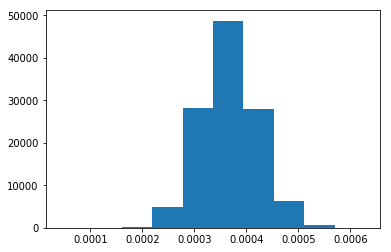

In [176]:
plt.hist(kl_scores);

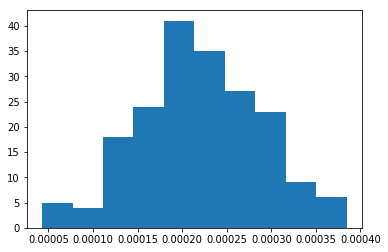

In [177]:
plt.hist(kl_scores[res==1]);

In [225]:
# Get subsets of enroll_ark and test_ark into memory

def ark_to_hdf5_raw(filename, num_utts = 100 ):
    HDFS_Name = filename+"_raw_dic.h5"
    store = pd.HDFStore(HDFS_Name)
    df_count = 0
    
    with open(FILE_DIR+filename, 'r') as f:
        working_data = []
        utt_id_past = ""
        for line in f:
            if(line[:2].isalpha()):
                utt_id = line[:line.index("[")-2]
                if not utt_id_past:
                    utt_id_past = utt_id
                
                if working_data:
                    pd.DataFrame(data=np.array(working_data, dtype='float64')).to_hdf(HDFS_Name, utt_id_past)
                
                    df_count+=1
                if df_count%num_utts==0: 
                    print("Utts processed: ", df_count)      
                utt_id_past = utt_id
                working_data = []
                
            else:
                # Add line as another row to the working matrix of df_utterance
                if "]" in line[-3:]: line = line[:-2]
                working_data.append(line.strip().split())
                
        if working_data: #Do same thing with tailing data
            pd.DataFrame(data=np.array(working_data, dtype='float64')).to_hdf(HDFS_Name, utt_id_past)
            print("Utts processed: ", df_count+1)  
            
            
    return store

# Archive

In [40]:
2939/1800946 # Greater percentage of target results in sample than in full dataset (0.01 %)

0.0016319201130961174

In [41]:
17892/len(pairs)

0.0015259300651206775

In [49]:
100/len(pairs['enroll'].unique()) # About 16% unique SPEAKERS, each with 5 unique utts

0.16339869281045752

In [148]:
np.random.RandomState(1)

u = np.random.choice(pairs['enroll'].unique(), 100)
samp_utts_enroll = enroll_utts.loc[u].values.flatten()
len(samp_utts_enroll)

enroll_ark_samp_tenth = dd.merge(enroll_ark, pd.DataFrame(index = samp_utts_enroll), left_on='utt', right_index=True)

p = ProgressBar()
p.register()
enroll_ark_samp_tenth = enroll_ark_samp_tenth.compute()

[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  8.5s


In [149]:
enroll_ark_samp_tenth.to_hdf('samp.h5', 'enroll_ark_samp_tenth')

Unique speakers in sample vs unique speakers in pairs

In [157]:
print("unique speakers in samp: ", len(u))
print("unique utts in samp: ", len(np.unique(samp_utts_enroll)))

unique speakers in samp:  100
unique utts in samp:  465


In [39]:
len(pairs['enroll'].unique())

612

Unique test speakers sample corresponding to uniq enroll speakers - results show that every enrolled speaker in the sample covers all unique test speakers. 

Our goal: ~10% of test_ark size to be a sample 

In [158]:
len(pairs[pairs['enroll'].isin(u)]['test_id'].unique())

19159

In [44]:
len(pairs['test_id'].unique()) 

19159

As all trials are independent, we take a subset of these test speakers and just commit ~10% to memory. *Use merge because getting multiindex.isin() doesn't work with dask*

In [159]:
u_t = np.random.choice(pairs['test_id'].unique(), 2000)
samp_utts_test = test_utts.loc[u_t].values.flatten()

test_ark_samp_tenth = dd.merge(test_ark, pd.DataFrame(index = samp_utts_test), left_on='utt', right_index=True)

In [160]:
test_ark_samp_tenth = test_ark_samp_tenth.compute()

[########################################] | 100% Completed |  3min 50.4s
[########################################] | 100% Completed |  3min 50.5s
[########################################] | 100% Completed |  3min 50.6s
[########################################] | 100% Completed |  3min 50.7s


In [162]:
test_ark_samp_tenth.to_hdf('samp.h5', 'test_ark_samp_tenth')